# 1.流动性


## 1.1货币

### DR007偏离度

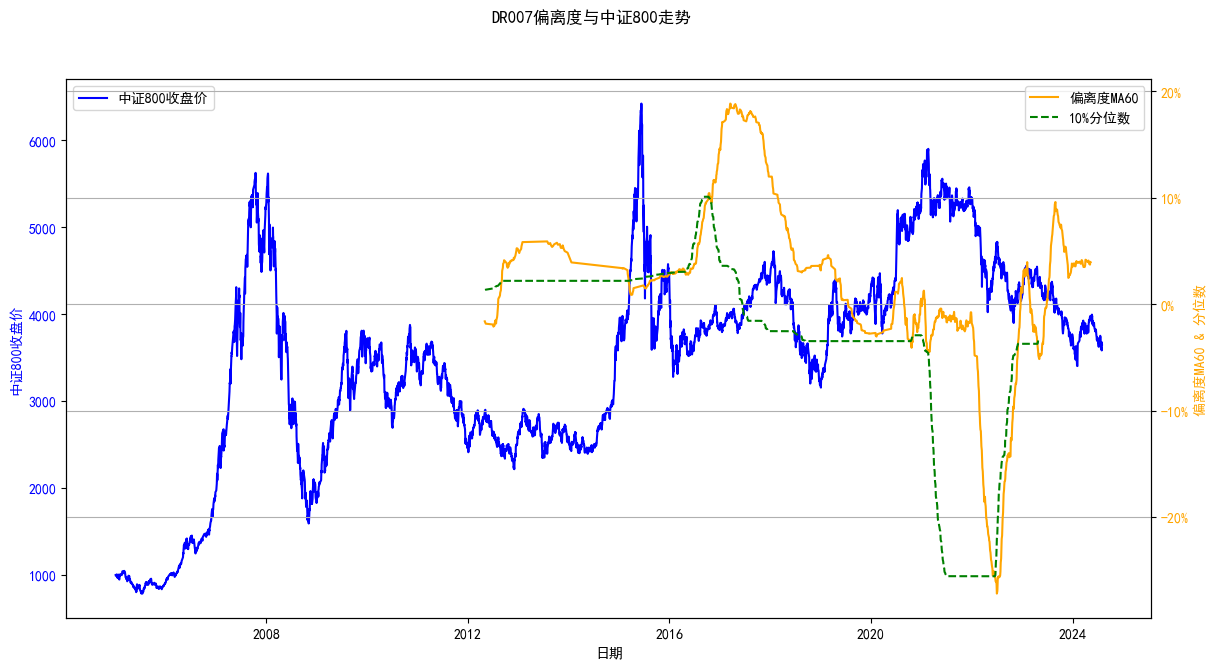

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx' 
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_dr007 = pd.read_excel(file_path, sheet_name='DR007', skiprows=6)
df_repurchase = pd.read_excel(file_path, sheet_name='7天逆回购利率', skiprows=6)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_dr007.columns = ['Date', 'DR007 Rate']
df_dr007['Date'] = pd.to_datetime(df_dr007['Date'], format='%Y-%m-%d', errors='coerce')
df_dr007.dropna(inplace=True)

df_repurchase.columns = ['Date', '7-day Repo Rate']
df_repurchase['Date'] = pd.to_datetime(df_repurchase['Date'], format='%Y-%m-%d', errors='coerce')
df_repurchase.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_dr007['DR007 Rate'] = pd.to_numeric(df_dr007['DR007 Rate'], errors='coerce')
df_repurchase['7-day Repo Rate'] = pd.to_numeric(df_repurchase['7-day Repo Rate'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算DR007偏离度及其60天移动平均
df_dr007_deviation = df_dr007.merge(df_repurchase, on='Date', how='inner')
df_dr007_deviation['Deviation'] = (df_dr007_deviation['DR007 Rate'] / df_dr007_deviation['7-day Repo Rate']) - 1
df_dr007_deviation['60-day Deviation MA'] = df_dr007_deviation['Deviation'].rolling(window=60).mean()

# 计算每个时间点的DR007的10%分位数
df_dr007_deviation['Quantile_10'] = df_dr007_deviation['60-day Deviation MA'].rolling(window=252).quantile(0.10)

# 绘制数据
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800收盘价', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800收盘价', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建另一个y轴用于DR007偏离度
ax2 = ax1.twinx()
ax2.plot(df_dr007_deviation['Date'], df_dr007_deviation['60-day Deviation MA'], label='偏离度MA60', color='orange')
ax2.plot(df_dr007_deviation['Date'], df_dr007_deviation['Quantile_10'], color='green', linestyle='--', label='10%分位数')
ax2.set_ylabel('偏离度MA60 & 分位数', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 将右侧Y轴的刻度设置为百分比
ax2.yaxis.set_major_formatter(PercentFormatter(1))

# 添加标题和图例
fig.suptitle('DR007偏离度与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

修正后的年化收益率: -2.14%
最大回撤: -27.34%
胜率: 3.32%
夏普比率: -0.66
卡玛比率: -0.08


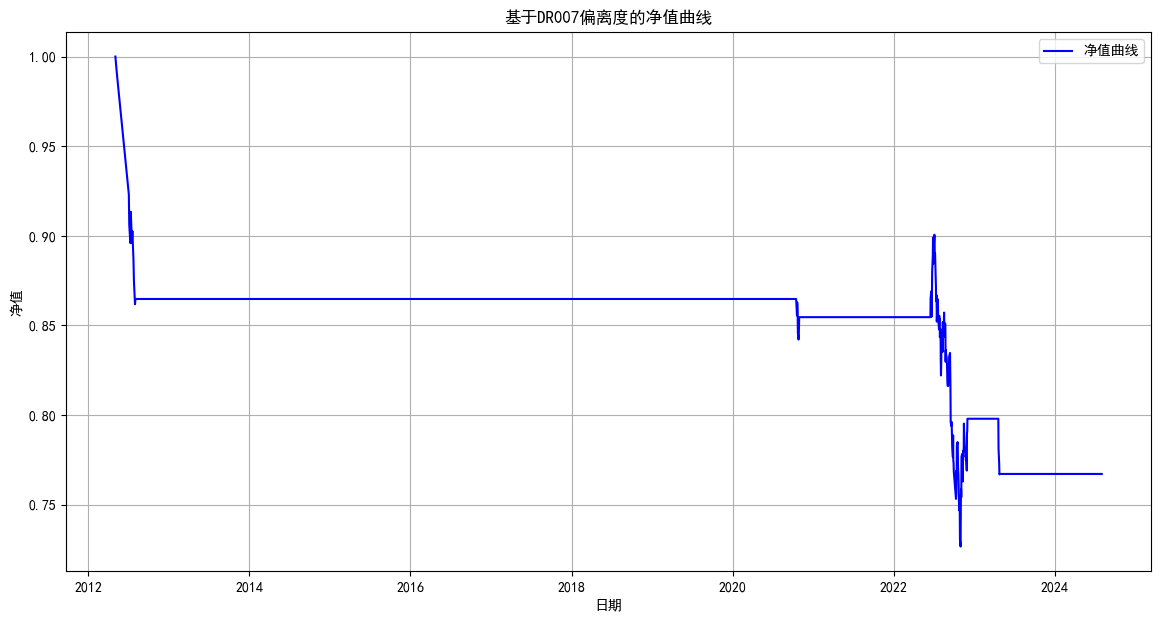

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取各个表格的数据
df_dr007 = pd.read_excel(file_path, sheet_name='DR007', skiprows=6)
df_repurchase = pd.read_excel(file_path, sheet_name='7天逆回购利率', skiprows=6)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_dr007.columns = ['Date', 'DR007 Rate']
df_dr007['Date'] = pd.to_datetime(df_dr007['Date'], format='%Y-%m-%d', errors='coerce')
df_dr007.dropna(inplace=True)

df_repurchase.columns = ['Date', '7-day Repo Rate']
df_repurchase['Date'] = pd.to_datetime(df_repurchase['Date'], format='%Y-%m-%d', errors='coerce')
df_repurchase.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_dr007['DR007 Rate'] = pd.to_numeric(df_dr007['DR007 Rate'], errors='coerce')
df_repurchase['7-day Repo Rate'] = pd.to_numeric(df_repurchase['7-day Repo Rate'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算DR007偏离度及其60天移动平均
df_dr007_deviation = df_dr007.merge(df_repurchase, on='Date', how='inner')
df_dr007_deviation['Deviation'] = (df_dr007_deviation['DR007 Rate'] / df_dr007_deviation['7-day Repo Rate']) - 1
df_dr007_deviation['60-day Deviation MA'] = df_dr007_deviation['Deviation'].rolling(window=60).mean()

# 计算每个时间点的DR007的10%分位数
df_dr007_deviation['Quantile_10'] = df_dr007_deviation['60-day Deviation MA'].rolling(window=252).quantile(0.10)

# 合并中证800数据
df_merged = df_csi800.merge(df_dr007_deviation[['Date', '60-day Deviation MA', 'Quantile_10']], on='Date', how='inner')

# 修改的策略逻辑：只有当偏离度低于分位数且低于某个阈值时，才开多仓；否则空仓
threshold = -0.01  # 设定一个合理的阈值
df_merged['Position'] = 0
df_merged.loc[(df_merged['60-day Deviation MA'] < df_merged['Quantile_10']) & 
              (df_merged['60-day Deviation MA'] < threshold), 'Position'] = 1

# 计算净值曲线
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod()

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 重新计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"修正后的年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于DR007偏离度的净值曲线')
plt.legend()
plt.grid(True)
plt.show()



### SHIBOR 1W



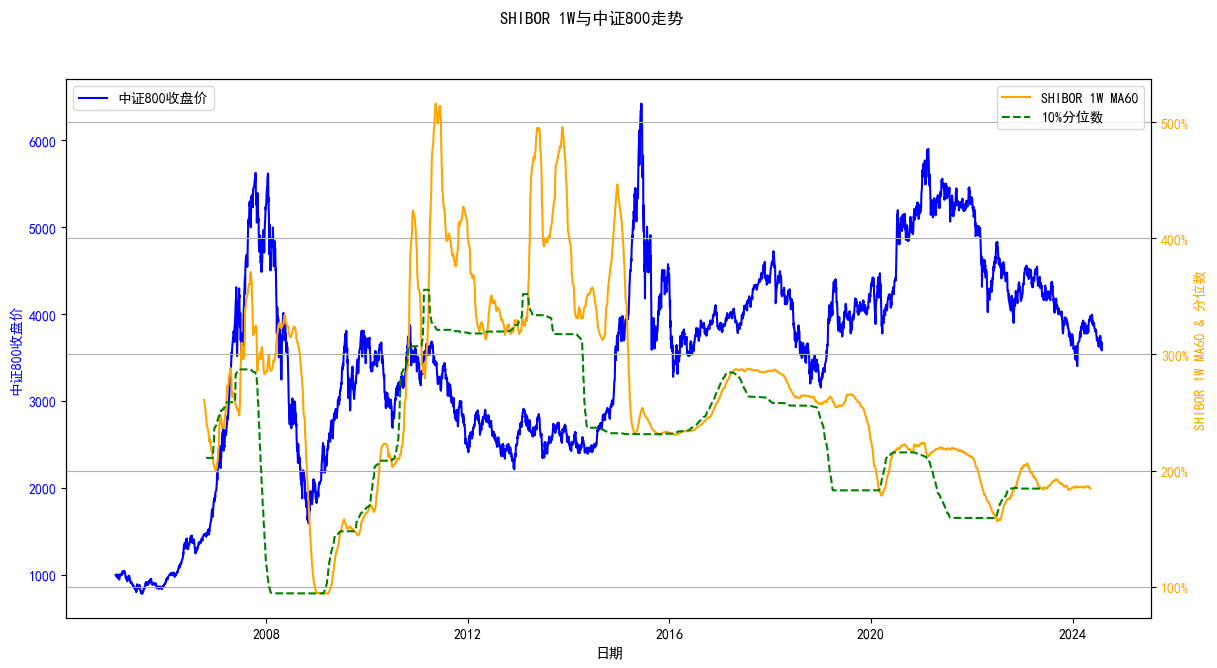

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 替换为实际文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_shibor1w = pd.read_excel(file_path, sheet_name='SHIBOR 1W', skiprows=6)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_shibor1w.columns = ['Date', 'SHIBOR 1W']
df_shibor1w['Date'] = pd.to_datetime(df_shibor1w['Date'], format='%Y-%m-%d', errors='coerce')
df_shibor1w.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_shibor1w['SHIBOR 1W'] = pd.to_numeric(df_shibor1w['SHIBOR 1W'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算SHIBOR 1W的60天移动平均
df_shibor1w['SHIBOR 1W MA60'] = df_shibor1w['SHIBOR 1W'].rolling(window=60).mean()

# 计算每个时间点的SHIBOR 1W的10%分位数
df_shibor1w['Quantile_10'] = df_shibor1w['SHIBOR 1W MA60'].rolling(window=252).quantile(0.10)

# 绘制数据
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800收盘价', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800收盘价', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建另一个y轴用于SHIBOR 1W
ax2 = ax1.twinx()
ax2.plot(df_shibor1w['Date'], df_shibor1w['SHIBOR 1W MA60'], label='SHIBOR 1W MA60', color='orange')
ax2.plot(df_shibor1w['Date'], df_shibor1w['Quantile_10'], color='green', linestyle='--', label='10%分位数')
ax2.set_ylabel('SHIBOR 1W MA60 & 分位数', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 将右侧Y轴的刻度设置为百分比
ax2.yaxis.set_major_formatter(PercentFormatter(1))

# 添加标题和图例
fig.suptitle('SHIBOR 1W与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()



年化收益率: 7.97%
最大回撤: -22.67%
胜率: 12.48%
夏普比率: 0.71
卡玛比率: 0.35


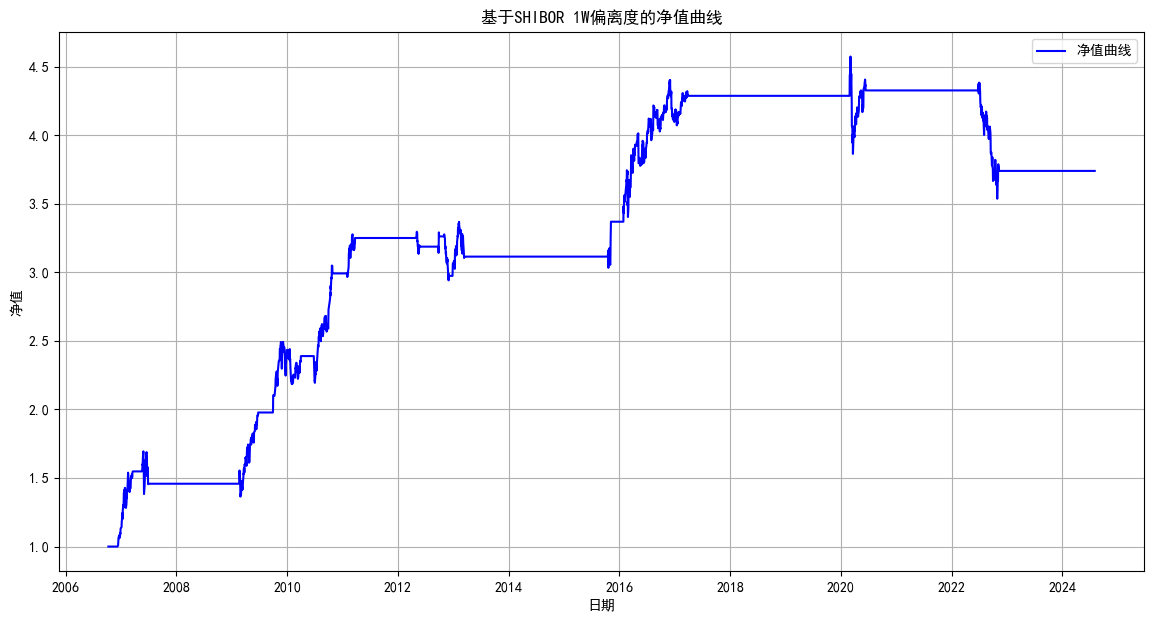

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取各个表格的数据
df_shibor1w = pd.read_excel(file_path, sheet_name='SHIBOR 1W', skiprows=6)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_shibor1w.columns = ['Date', 'SHIBOR 1W']
df_shibor1w['Date'] = pd.to_datetime(df_shibor1w['Date'], format='%Y-%m-%d', errors='coerce')
df_shibor1w.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_shibor1w['SHIBOR 1W'] = pd.to_numeric(df_shibor1w['SHIBOR 1W'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算SHIBOR 1W的60天移动平均
df_shibor1w['SHIBOR 1W MA60'] = df_shibor1w['SHIBOR 1W'].rolling(window=60).mean()

# 计算每个时间点的SHIBOR 1W的10%分位数
df_shibor1w['Quantile_10'] = df_shibor1w['SHIBOR 1W MA60'].rolling(window=252).quantile(0.10)

# 合并中证800数据
df_merged = df_csi800.merge(df_shibor1w[['Date', 'SHIBOR 1W MA60', 'Quantile_10']], on='Date', how='inner')

# 信号生成：偏离度小于10%分位数，开多仓；否则空仓
df_merged['Position'] = 0
df_merged.loc[df_merged['SHIBOR 1W MA60'] < df_merged['Quantile_10'], 'Position'] = 1

# 计算净值曲线
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change().shift(-1)  # 下一日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Net Value'] = (1 + df_merged['Strategy Return'].fillna(0)).cumprod()

# 计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = df_merged['Net Value'].iloc[-1] ** (252 / len(df_merged)) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于SHIBOR 1W偏离度的净值曲线')
plt.legend()
plt.grid(True)
plt.show()



## 1.2信用

### M1同比

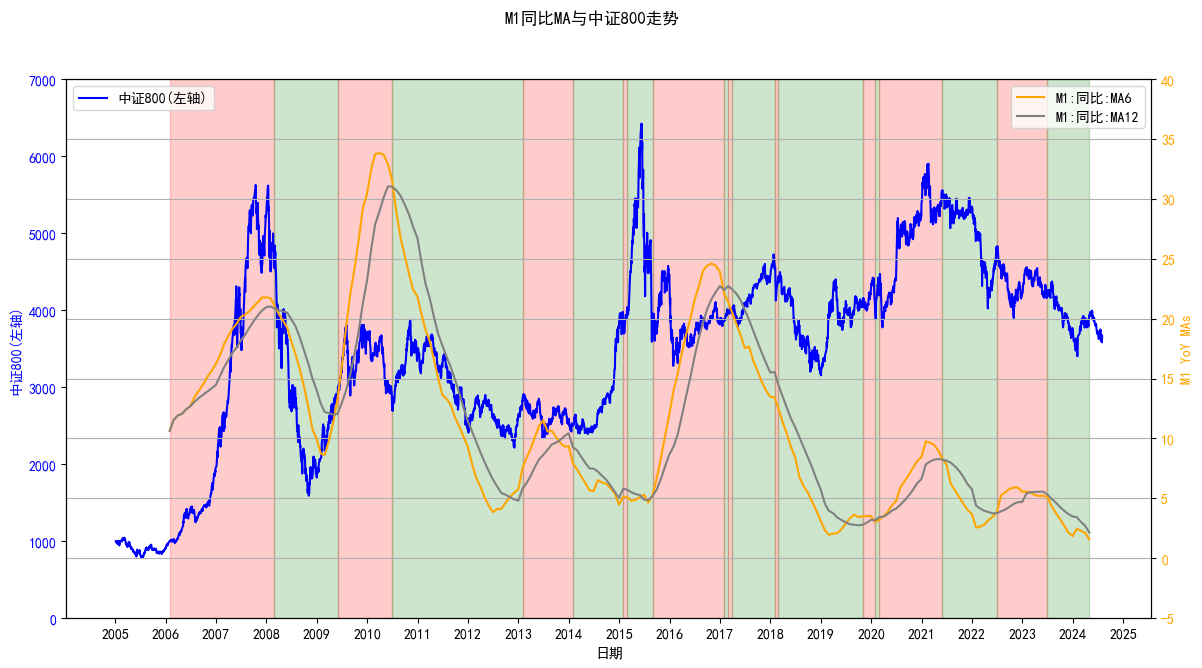

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'   
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_m1_yoy = pd.read_excel(file_path, sheet_name='M1同比', skiprows=10)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m1_yoy = df_m1_yoy.iloc[1:].reset_index(drop=True)  # 重置索引
df_m1_yoy.columns = ['Date', 'M1 YoY']
df_m1_yoy['Date'] = pd.to_datetime(df_m1_yoy['Date'], format='%Y-%m-%d', errors='coerce')
df_m1_yoy.dropna(inplace=True)

# 转换为数值类型
df_m1_yoy['M1 YoY'] = pd.to_numeric(df_m1_yoy['M1 YoY'], errors='coerce')

# 确保数据按时间升序排序
df_m1_yoy = df_m1_yoy.sort_values(by='Date').reset_index(drop=True)

# 计算6个月和12个月移动平均线
df_m1_yoy['M1: YoY: MA6'] = df_m1_yoy['M1 YoY'].rolling(window=6, min_periods=1).mean()
df_m1_yoy['M1: YoY: MA12'] = df_m1_yoy['M1 YoY'].rolling(window=12, min_periods=1).mean()

# 计算6个月和12个月的指数移动平均线（可选）
df_m1_yoy['M1: YoY: EMA6'] = df_m1_yoy['M1 YoY'].ewm(span=6, adjust=False).mean()
df_m1_yoy['M1: YoY: EMA12'] = df_m1_yoy['M1 YoY'].ewm(span=12, adjust=False).mean()

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 绘制图表
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800(左轴)', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800(左轴)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于M1同比MA6和MA12
ax2 = ax1.twinx()
ax2.plot(df_m1_yoy['Date'], df_m1_yoy['M1: YoY: MA6'], label='M1:同比:MA6', color='orange')
ax2.plot(df_m1_yoy['Date'], df_m1_yoy['M1: YoY: MA12'], label='M1:同比:MA12', color='grey')
# 如果使用EMA线，可以添加以下两行替换MA线
# ax2.plot(df_m1_yoy['Date'], df_m1_yoy['M1: YoY: EMA6'], label='M1:同比:EMA6', color='orange', linestyle='dashed')
# ax2.plot(df_m1_yoy['Date'], df_m1_yoy['M1: YoY: EMA12'], label='M1:同比:EMA12', color='grey', linestyle='dashed')

ax2.set_ylabel('M1 YoY MAs', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([-5, 40])

# 根据MA12的趋势添加连续的背景色（向下绿色，向上红色）
start_date = df_m1_yoy.iloc[0]['Date']
color = 'green' if df_m1_yoy.iloc[0]['M1: YoY: MA12'] > df_m1_yoy.iloc[1]['M1: YoY: MA12'] else 'red'

for i in range(1, len(df_m1_yoy)):
    current_trend = df_m1_yoy.iloc[i]['M1: YoY: MA12'] > df_m1_yoy.iloc[i - 1]['M1: YoY: MA12']
    if (color == 'red' and not current_trend) or (color == 'green' and current_trend):
        ax1.axvspan(start_date, df_m1_yoy.iloc[i]['Date'], color=color, alpha=0.2)
        start_date = df_m1_yoy.iloc[i]['Date']
        color = 'red' if color == 'green' else 'green'

# 添加最后一个色块
ax1.axvspan(start_date, df_m1_yoy.iloc[-1]['Date'], color=color, alpha=0.2)

# 添加标题和图例
fig.suptitle('M1同比MA与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 格式化x轴日期
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True)
plt.show()

年化收益率: -2.05%
最大回撤: -51.21%
胜率: 28.57%
夏普比率: 0.46
卡玛比率: -0.04


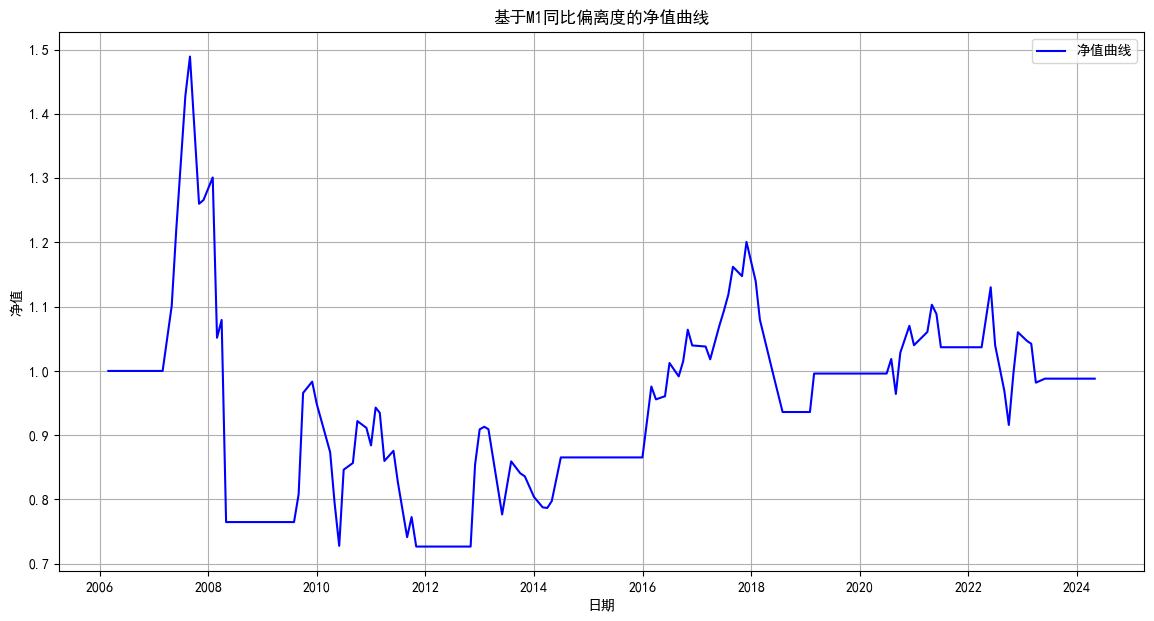

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取各个表格的数据
df_m1_yoy = pd.read_excel(file_path, sheet_name='M1同比', skiprows=10)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m1_yoy = df_m1_yoy.iloc[1:].reset_index(drop=True)  # 重置索引
df_m1_yoy.columns = ['Date', 'M1 YoY']
df_m1_yoy['Date'] = pd.to_datetime(df_m1_yoy['Date'], format='%Y-%m-%d', errors='coerce')
df_m1_yoy.dropna(inplace=True)

# 转换为数值类型
df_m1_yoy['M1 YoY'] = pd.to_numeric(df_m1_yoy['M1 YoY'], errors='coerce')

# 计算6个月和12个月移动平均线
df_m1_yoy['M1: YoY: MA6'] = df_m1_yoy['M1 YoY'].rolling(window=6).mean()
df_m1_yoy['M1: YoY: MA12'] = df_m1_yoy['M1 YoY'].rolling(window=12).mean()

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 合并中证800数据
df_merged = df_csi800.merge(df_m1_yoy[['Date', 'M1: YoY: MA6', 'M1: YoY: MA12']], on='Date', how='inner')

# 信号生成：M1 YoY MA6大于MA12，开多仓；否则空仓
df_merged['Position'] = 0
df_merged.loc[df_merged['M1: YoY: MA6'] > df_merged['M1: YoY: MA12'], 'Position'] = 1

# 计算净值曲线
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change().shift(-1)  # 下一日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Net Value'] = (1 + df_merged['Strategy Return'].fillna(0)).cumprod()

# 计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = df_merged['Net Value'].iloc[-1] ** (252 / len(df_merged)) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于M1同比偏离度的净值曲线')
plt.legend()
plt.grid(True)
plt.show()


### M1 同比-PPI 同比

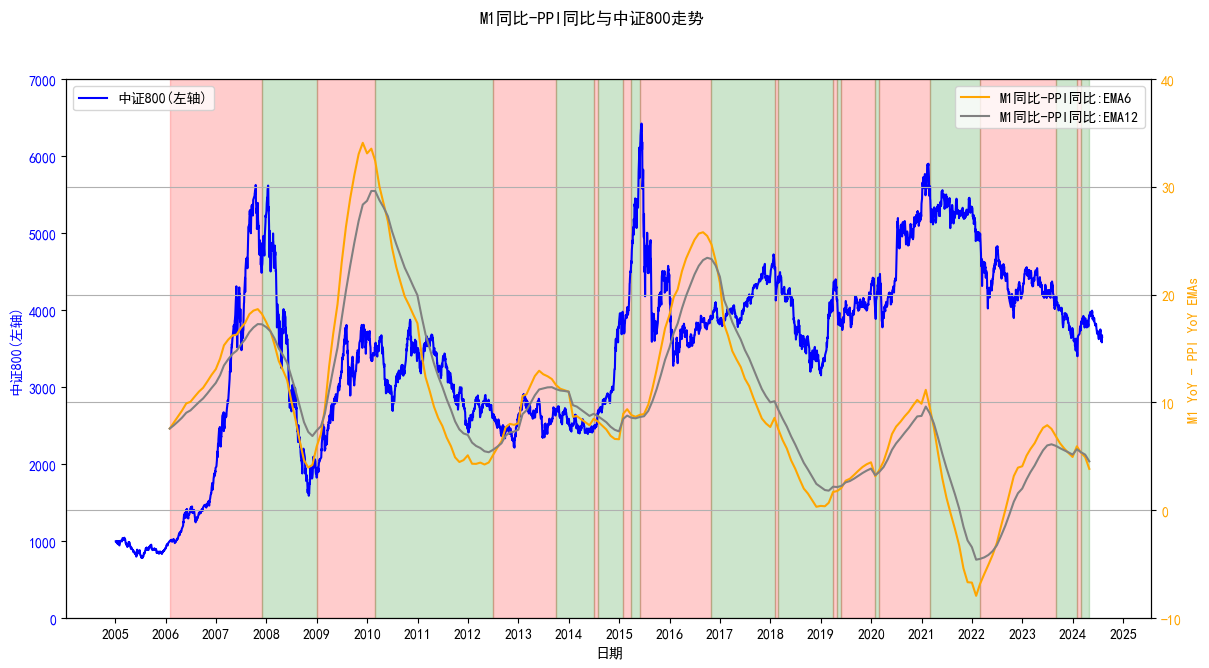

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 读取M1同比和PPI数据
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  
df_m1 = pd.read_excel(file_path, sheet_name='M1同比', skiprows=10)
df_ppi = pd.read_excel(file_path, sheet_name='PPI', skiprows=10)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m1 = df_m1.iloc[1:].reset_index(drop=True)  # 重置索引
df_m1.columns = ['Date', 'M1 YoY']
df_m1['Date'] = pd.to_datetime(df_m1['Date'], format='%Y-%m-%d', errors='coerce')
df_m1.dropna(inplace=True)

df_ppi = df_ppi.iloc[1:].reset_index(drop=True)  # 重置索引
df_ppi.columns = ['Date', 'PPI YoY']
df_ppi['Date'] = pd.to_datetime(df_ppi['Date'], format='%Y-%m-%d', errors='coerce')
df_ppi.dropna(inplace=True)

# 转换为数值类型
df_m1['M1 YoY'] = pd.to_numeric(df_m1['M1 YoY'], errors='coerce')
df_ppi['PPI YoY'] = pd.to_numeric(df_ppi['PPI YoY'], errors='coerce')

# 合并M1和PPI数据以计算差值
df_merged = pd.merge(df_m1, df_ppi, on='Date')
df_merged['M1 YoY - PPI YoY'] = df_merged['M1 YoY'] - df_merged['PPI YoY']

# 确保数据按时间升序排序
df_merged = df_merged.sort_values(by='Date').reset_index(drop=True)

# 计算6个月和12个月的指数移动平均线
df_merged['M1 YoY - PPI YoY: EMA6'] = df_merged['M1 YoY - PPI YoY'].ewm(span=6, adjust=False).mean()
df_merged['M1 YoY - PPI YoY: EMA12'] = df_merged['M1 YoY - PPI YoY'].ewm(span=12, adjust=False).mean()

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 绘制图表
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800(左轴)', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800(左轴)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于M1同比-PPI同比EMA6和EMA12
ax2 = ax1.twinx()
ax2.plot(df_merged['Date'], df_merged['M1 YoY - PPI YoY: EMA6'], label='M1同比-PPI同比:EMA6', color='orange')
ax2.plot(df_merged['Date'], df_merged['M1 YoY - PPI YoY: EMA12'], label='M1同比-PPI同比:EMA12', color='grey')
ax2.set_ylabel('M1 YoY - PPI YoY EMAs', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([-10, 40])

# 根据EMA12的趋势添加连续的背景色（向下绿色，向上红色）
start_date = df_merged.iloc[0]['Date']
color = 'green' if df_merged.iloc[1]['M1 YoY - PPI YoY: EMA12'] < df_merged.iloc[0]['M1 YoY - PPI YoY: EMA12'] else 'red'

for i in range(1, len(df_merged)):
    current_trend = df_merged.iloc[i]['M1 YoY - PPI YoY: EMA12'] < df_merged.iloc[i - 1]['M1 YoY - PPI YoY: EMA12']
    if (color == 'green' and not current_trend) or (color == 'red' and current_trend):
        ax1.axvspan(start_date, df_merged.iloc[i]['Date'], color=color, alpha=0.2)
        start_date = df_merged.iloc[i]['Date']
        color = 'red' if color == 'green' else 'green'

# 添加最后一个色块
ax1.axvspan(start_date, df_merged.iloc[-1]['Date'], color=color, alpha=0.2)

# 添加标题和图例
fig.suptitle('M1同比-PPI同比与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 格式化x轴日期
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True)
plt.show()


修正后的年化收益率: 5.14%
最大回撤: -34.11%
胜率: 42.55%
夏普比率: 3.12
卡玛比率: 0.15


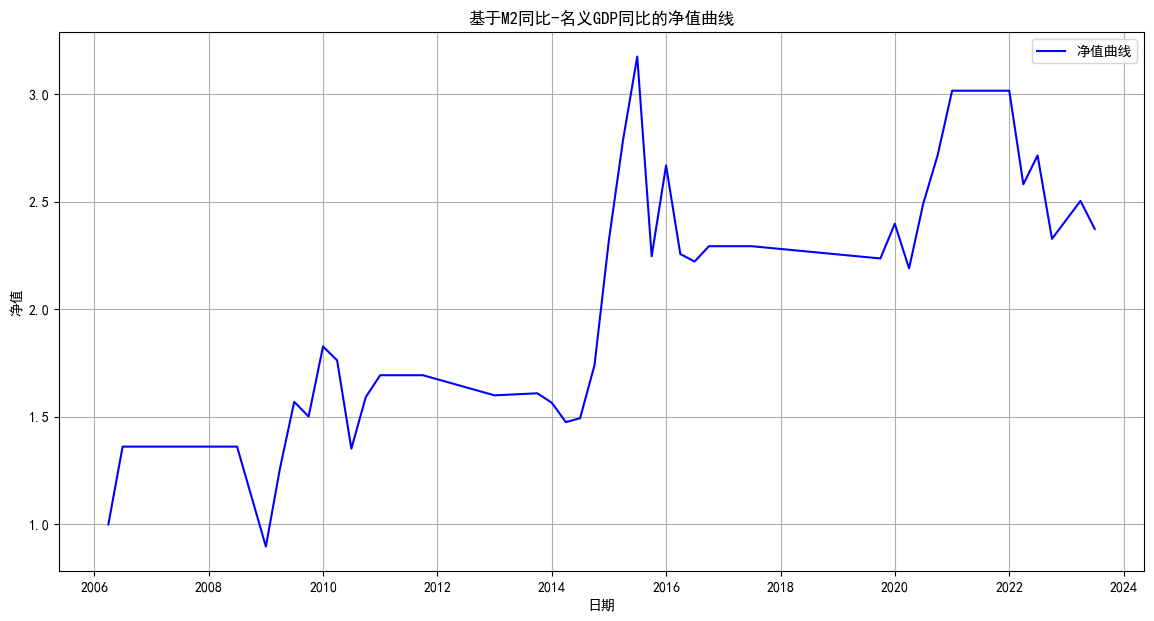

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 请替换为实际的文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_m2 = pd.read_excel(file_path, sheet_name='M2同比', skiprows=4)
df_gdp = pd.read_excel(file_path, sheet_name='GDP同比', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m2 = df_m2.iloc[1:].reset_index(drop=True)  # 重置索引
df_m2.columns = ['Date', 'M2 YoY']
df_m2['Date'] = pd.to_datetime(df_m2['Date'], format='%Y-%m-%d', errors='coerce')
df_m2.dropna(inplace=True)

df_gdp = df_gdp.iloc[1:].reset_index(drop=True)  # 重置索引
df_gdp.columns = ['Date', 'Nominal GDP YoY']
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'], format='%Y-%m-%d', errors='coerce')
df_gdp.dropna(inplace=True)

# 转换为数值类型
df_m2['M2 YoY'] = pd.to_numeric(df_m2['M2 YoY'], errors='coerce')
df_gdp['Nominal GDP YoY'] = pd.to_numeric(df_gdp['Nominal GDP YoY'], errors='coerce')

# 合并M2和名义GDP数据以计算差值
df_merged = pd.merge(df_m2, df_gdp, on='Date')
df_merged['M2 YoY - Nominal GDP YoY'] = df_merged['M2 YoY'] - df_merged['Nominal GDP YoY']

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 合并中证800数据
df_merged = df_csi800.merge(df_merged[['Date', 'M2 YoY - Nominal GDP YoY']], on='Date', how='inner')

# 修改的策略逻辑：M2 YoY - Nominal GDP YoY > 一定的阈值（0.5%），开多仓；否则空仓
threshold = 0.005  # 设定一个合理的阈值
df_merged['Position'] = 0
df_merged.loc[df_merged['M2 YoY - Nominal GDP YoY'] > threshold, 'Position'] = 1

# 计算净值曲线
initial_value = 1  # 初始净值为1
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod() * initial_value

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 重新计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"修正后的年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于M2同比-名义GDP同比的净值曲线')
plt.legend()
plt.grid(True)
plt.show()


### M2 周比-名义GDP 增速


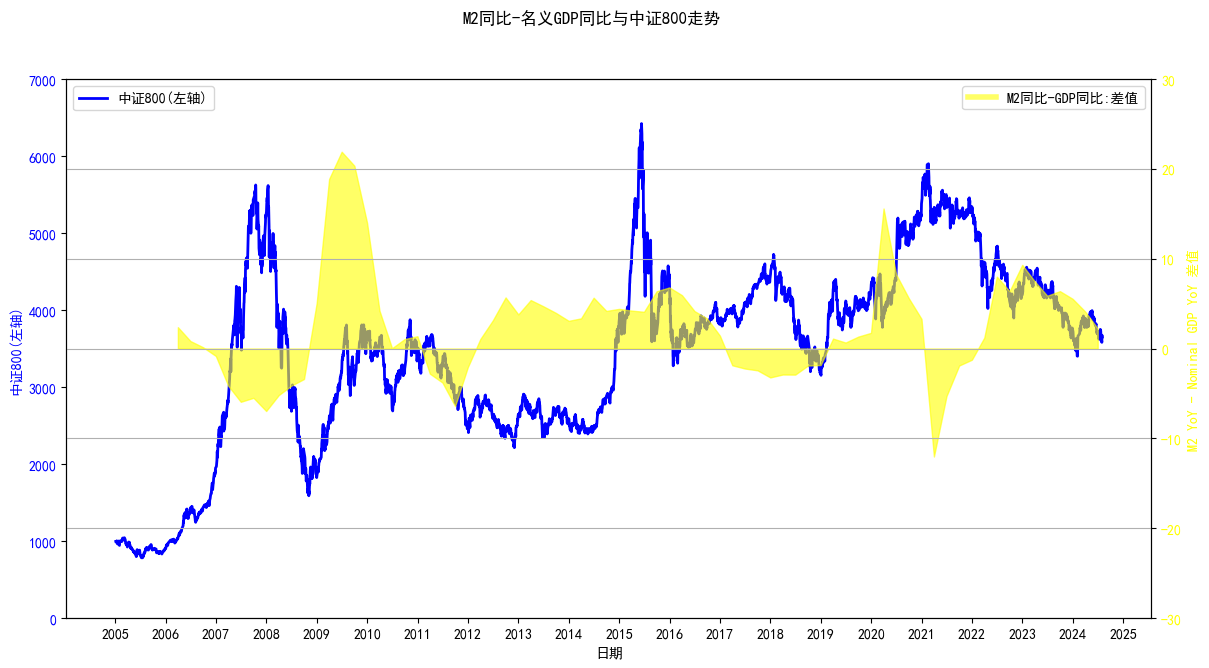

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 请替换为实际的文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_m2 = pd.read_excel(file_path, sheet_name='M2同比', skiprows=4)
df_gdp = pd.read_excel(file_path, sheet_name='GDP同比', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m2 = df_m2.iloc[1:].reset_index(drop=True)  # 重置索引
df_m2.columns = ['Date', 'M2 YoY']
df_m2['Date'] = pd.to_datetime(df_m2['Date'], format='%Y-%m-%d', errors='coerce')
df_m2.dropna(inplace=True)

df_gdp = df_gdp.iloc[1:].reset_index(drop=True)  # 重置索引
df_gdp.columns = ['Date', 'Nominal GDP YoY']
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'], format='%Y-%m-%d', errors='coerce')
df_gdp.dropna(inplace=True)

# 转换为数值类型
df_m2['M2 YoY'] = pd.to_numeric(df_m2['M2 YoY'], errors='coerce')
df_gdp['Nominal GDP YoY'] = pd.to_numeric(df_gdp['Nominal GDP YoY'], errors='coerce')

# 合并M2和名义GDP数据以计算差值
df_merged = pd.merge(df_m2, df_gdp, on='Date')
df_merged['M2 YoY - Nominal GDP YoY'] = df_merged['M2 YoY'] - df_merged['Nominal GDP YoY']

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 绘制图表
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
line1, = ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800(左轴)', color='blue', linewidth=2)
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800(左轴)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于M2同比-名义GDP同比差值
ax2 = ax1.twinx()
bar1 = ax2.fill_between(df_merged['Date'], 0, df_merged['M2 YoY - Nominal GDP YoY'], color='yellow', alpha=0.6)
ax2.set_ylabel('M2 YoY - Nominal GDP YoY 差值', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax2.set_ylim([-30, 30])

# 添加标题和图例
fig.suptitle('M2同比-名义GDP同比与中证800走势')
ax1.legend([line1], ['中证800(左轴)'], loc='upper left')
# 创建一个代理艺术家来表示fill_between图例项
bar_legend = plt.Line2D([0], [0], color='yellow', lw=4, alpha=0.6)
ax2.legend([bar_legend], ['M2同比-GDP同比:差值'], loc='upper right')

# 格式化x轴日期
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True)
plt.show()


修正后的年化收益率: 5.81%
最大回撤: -52.09%
胜率: 42.55%
夏普比率: 2.55
卡玛比率: 0.11


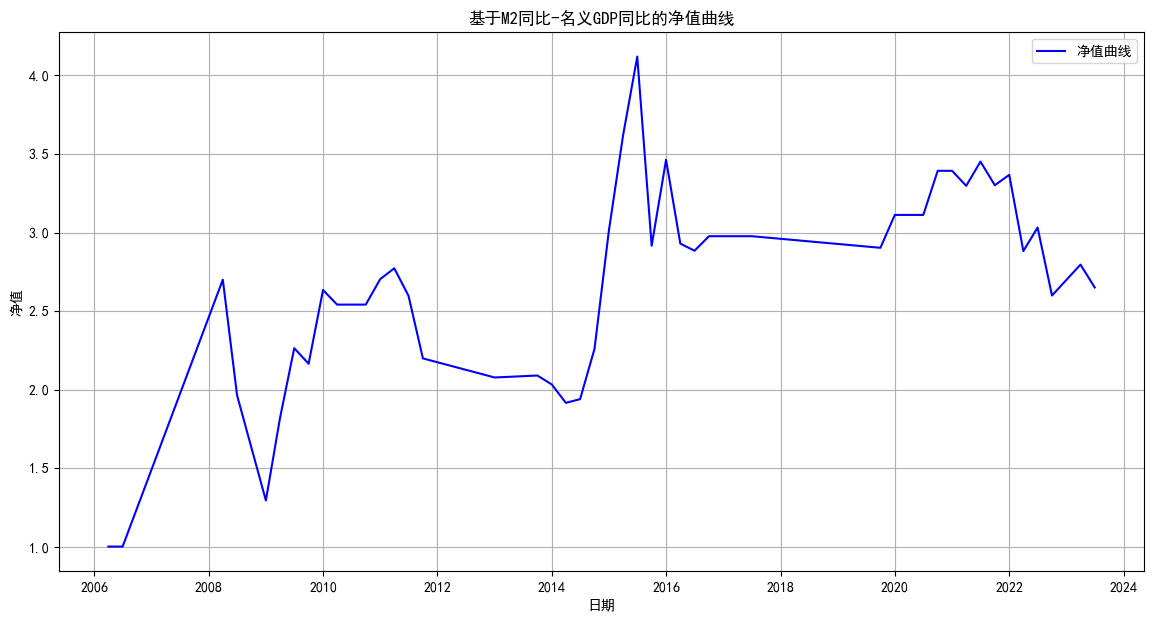

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 请替换为实际的文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_m2 = pd.read_excel(file_path, sheet_name='M2同比', skiprows=4)
df_gdp = pd.read_excel(file_path, sheet_name='GDP同比', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 清理并处理数据
df_m2 = df_m2.iloc[1:].reset_index(drop=True)  # 重置索引
df_m2.columns = ['Date', 'M2 YoY']
df_m2['Date'] = pd.to_datetime(df_m2['Date'], format='%Y-%m-%d', errors='coerce')
df_m2.dropna(inplace=True)

df_gdp = df_gdp.iloc[1:].reset_index(drop=True)  # 重置索引
df_gdp.columns = ['Date', 'Nominal GDP YoY']
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'], format='%Y-%m-%d', errors='coerce')
df_gdp.dropna(inplace=True)

# 转换为数值类型
df_m2['M2 YoY'] = pd.to_numeric(df_m2['M2 YoY'], errors='coerce')
df_gdp['Nominal GDP YoY'] = pd.to_numeric(df_gdp['Nominal GDP YoY'], errors='coerce')

# 合并M2和名义GDP数据以计算差值
df_merged = pd.merge(df_m2, df_gdp, on='Date')
df_merged['M2 YoY - Nominal GDP YoY'] = df_merged['M2 YoY'] - df_gdp['Nominal GDP YoY']

# 清理中证800数据
df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 合并中证800数据
df_merged = df_csi800.merge(df_merged[['Date', 'M2 YoY - Nominal GDP YoY']], on='Date', how='inner')

# 信号生成：M2 YoY - Nominal GDP YoY > 0，开多仓；否则空仓
df_merged['Position'] = 0
df_merged.loc[df_merged['M2 YoY - Nominal GDP YoY'] > 0, 'Position'] = 1

# 计算净值曲线
initial_value = 1  # 初始净值为1
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod() * initial_value

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"修正后的年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于M2同比-名义GDP同比的净值曲线')
plt.legend()
plt.grid(True)
plt.show()


# 2.经济面

## 2.1经济

### PMI

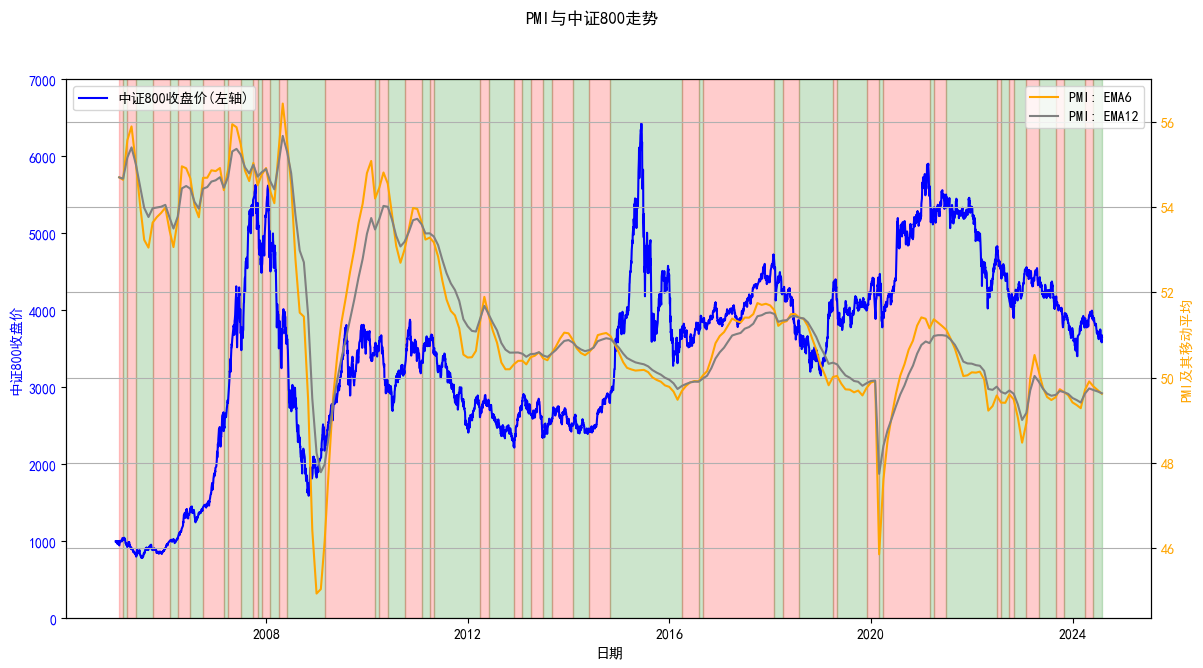

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 替换为实际文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_pmi = pd.read_excel(file_path, sheet_name='PMI', skiprows=7)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_pmi.columns = ['Date', 'PMI']
df_pmi['Date'] = pd.to_datetime(df_pmi['Date'], format='%Y-%m-%d', errors='coerce')
df_pmi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_pmi['PMI'] = pd.to_numeric(df_pmi['PMI'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 确保数据按时间升序排序
df_pmi = df_pmi.sort_values(by='Date').reset_index(drop=True)

# 计算PMI的6个月和12个月指数移动平均线
df_pmi['PMI EMA6'] = df_pmi['PMI'].ewm(span=6, adjust=False).mean()
df_pmi['PMI EMA12'] = df_pmi['PMI'].ewm(span=12, adjust=False).mean()

# 绘制数据
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800收盘价(左轴)', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800收盘价', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于PMI及其指数移动平均
ax2 = ax1.twinx()
ax2.plot(df_pmi['Date'], df_pmi['PMI EMA6'], label='PMI: EMA6', color='orange')
ax2.plot(df_pmi['Date'], df_pmi['PMI EMA12'], label='PMI: EMA12', color='grey')
ax2.set_ylabel('PMI及其移动平均', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 根据PMI的变化趋势添加背景色（向上红色，向下绿色）
start_date = df_pmi.iloc[0]['Date']
color = 'red' if df_pmi.iloc[0]['PMI EMA12'] > df_pmi.iloc[1]['PMI EMA12'] else 'green'

for i in range(1, len(df_pmi)):
    current_trend = df_pmi.iloc[i]['PMI EMA12'] > df_pmi.iloc[i - 1]['PMI EMA12']
    if (color == 'green' and current_trend) or (color == 'red' and not current_trend):
        ax1.axvspan(start_date, df_pmi.iloc[i]['Date'], color=color, alpha=0.2)
        start_date = df_pmi.iloc[i]['Date']
        color = 'green' if color == 'red' else 'red'

# 添加最后一个色块
ax1.axvspan(start_date, df_pmi.iloc[-1]['Date'], color=color, alpha=0.2)

# 添加标题和图例
fig.suptitle('PMI与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()



年化收益率: 9.87%
最大回撤: -34.40%
胜率: 29.75%
夏普比率: 2.97
卡玛比率: 0.29


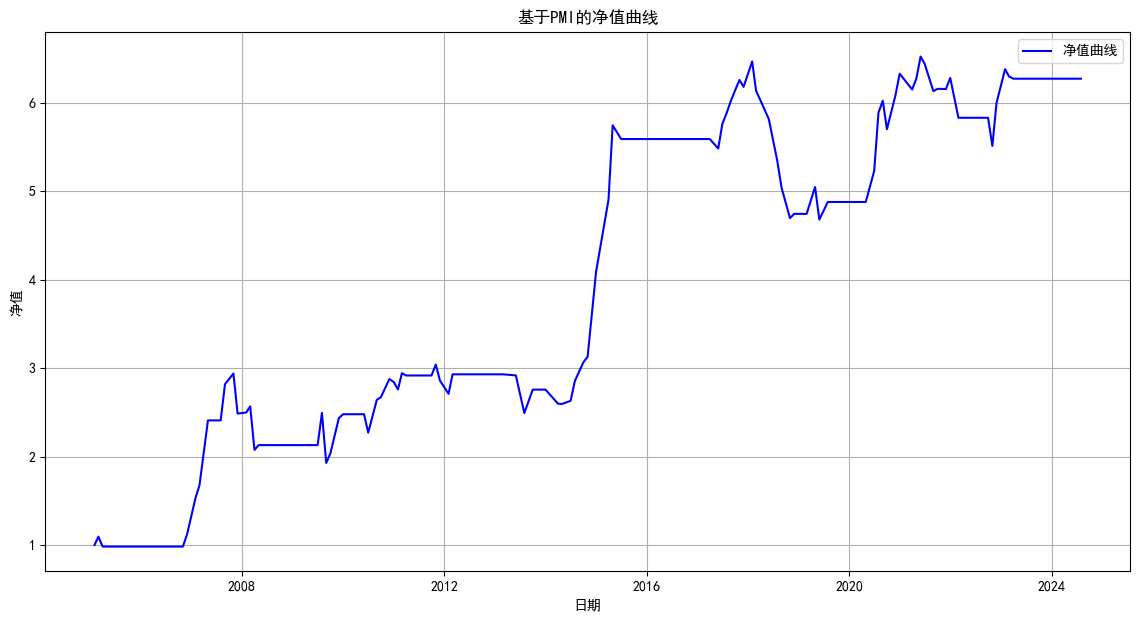

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取各个表格的数据
df_pmi = pd.read_excel(file_path, sheet_name='PMI', skiprows=7)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_pmi.columns = ['Date', 'PMI']
df_pmi['Date'] = pd.to_datetime(df_pmi['Date'], format='%Y-%m-%d', errors='coerce')
df_pmi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_pmi['PMI'] = pd.to_numeric(df_pmi['PMI'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算PMI的6个月和12个月移动平均
df_pmi['PMI MA6'] = df_pmi['PMI'].rolling(window=6).mean()
df_pmi['PMI MA12'] = df_pmi['PMI'].rolling(window=12).mean()

# 合并中证800数据
df_merged = df_csi800.merge(df_pmi[['Date', 'PMI MA6', 'PMI MA12']], on='Date', how='inner')

# 信号生成：PMI MA6 大于 PMI MA12 时开多仓；否则空仓
df_merged['Position'] = 0
df_merged.loc[df_merged['PMI MA6'] > df_merged['PMI MA12'], 'Position'] = 1

# 计算净值曲线
initial_value = 1  # 初始净值为1
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position']
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod() * initial_value

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 重新计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于PMI的净值曲线')
plt.legend()
plt.grid(True)
plt.show()

## 2.2通胀

### CPI同比

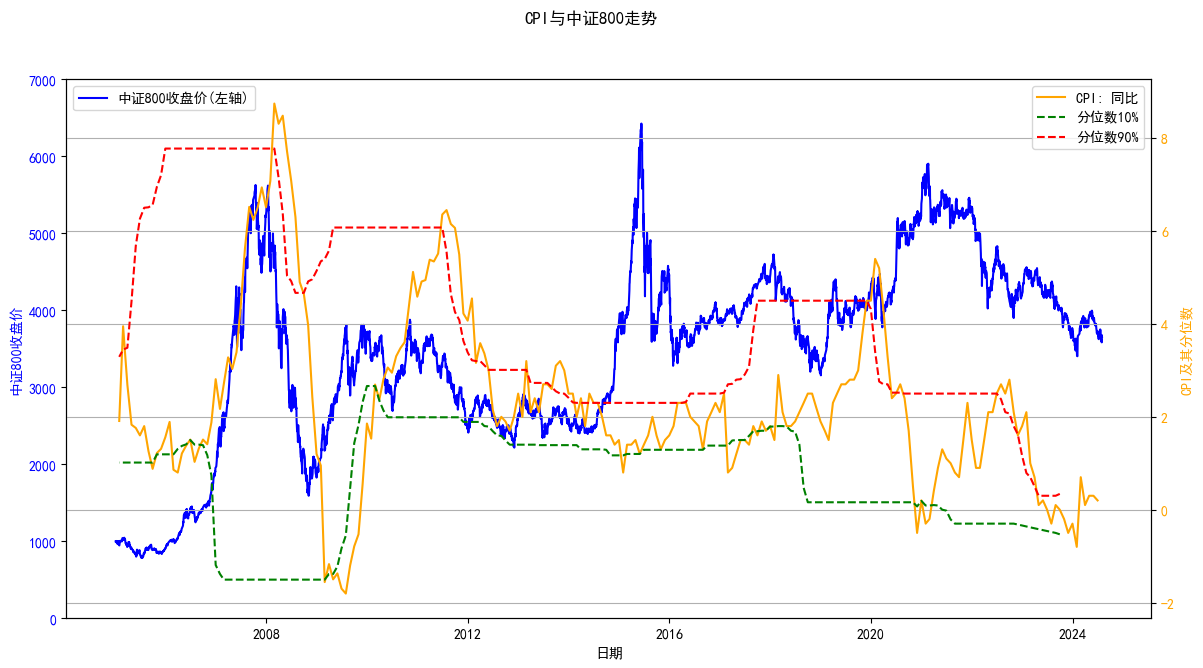

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 替换为实际文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_cpi = pd.read_excel(file_path, sheet_name='CPI', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_cpi.columns = ['Date', 'CPI YoY']
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'], format='%Y-%m-%d', errors='coerce')
df_cpi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_cpi['CPI YoY'] = pd.to_numeric(df_cpi['CPI YoY'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算每个时间点的CPI的10%和90%分位数，使用较小的滚动窗口
window_size = 30  # 滚动窗口大小
min_periods = 10  # 最小数据点数目
df_cpi['Quantile_10'] = df_cpi['CPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.10), raw=False)
df_cpi['Quantile_90'] = df_cpi['CPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.90), raw=False)

# 绘制数据
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800收盘价(左轴)', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800收盘价', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于CPI及其分位数
ax2 = ax1.twinx()
ax2.plot(df_cpi['Date'], df_cpi['CPI YoY'], label='CPI: 同比', color='orange')
ax2.plot(df_cpi['Date'], df_cpi['Quantile_10'], color='green', linestyle='--', label='分位数10%')
ax2.plot(df_cpi['Date'], df_cpi['Quantile_90'], color='red', linestyle='--', label='分位数90%')
ax2.set_ylabel('CPI及其分位数', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 添加标题和图例
fig.suptitle('CPI与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()




年化收益率: 9.33%
最大回撤: -22.69%
胜率: 19.75%
夏普比率: 3.20
卡玛比率: 0.41


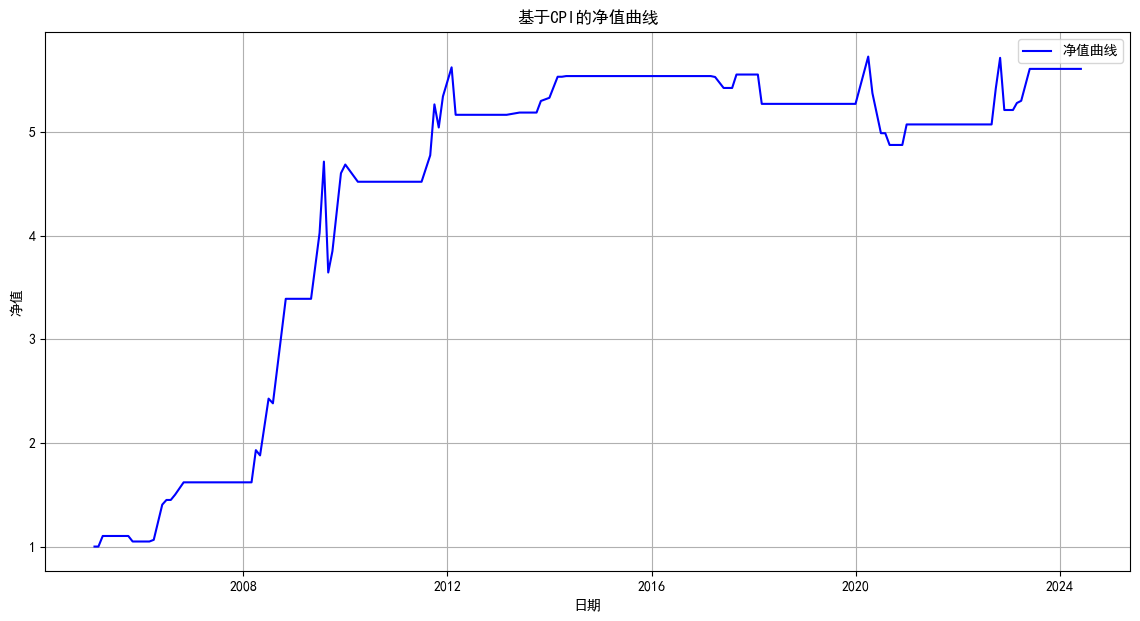

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 替换为实际文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_cpi = pd.read_excel(file_path, sheet_name='CPI', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_cpi.columns = ['Date', 'CPI YoY']
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'], format='%Y-%m-%d', errors='coerce')
df_cpi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_cpi['CPI YoY'] = pd.to_numeric(df_cpi['CPI YoY'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算每个时间点的CPI的10%和90%分位数，使用较小的滚动窗口
window_size = 30  # 滚动窗口大小
min_periods = 10  # 最小数据点数目
df_cpi['Quantile_10'] = df_cpi['CPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.10), raw=False)
df_cpi['Quantile_90'] = df_cpi['CPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.90), raw=False)

# 合并中证800数据
df_merged = df_csi800.merge(df_cpi[['Date', 'CPI YoY', 'Quantile_10', 'Quantile_90']], on='Date', how='inner')

# 信号生成：CPI低于10%分位数时开多仓，高于90%分位数时空仓，否则持仓不变
df_merged['Position'] = 0
df_merged.loc[df_merged['CPI YoY'] < df_merged['Quantile_10'], 'Position'] = 1
df_merged.loc[df_merged['CPI YoY'] > df_merged['Quantile_90'], 'Position'] = -1

# 计算净值曲线
initial_value = 1  # 初始净值为1
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position'].shift(1)  # 使用前一日的仓位
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod() * initial_value

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 重新计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于CPI的净值曲线')
plt.legend()
plt.grid(True)
plt.show()


### PPI

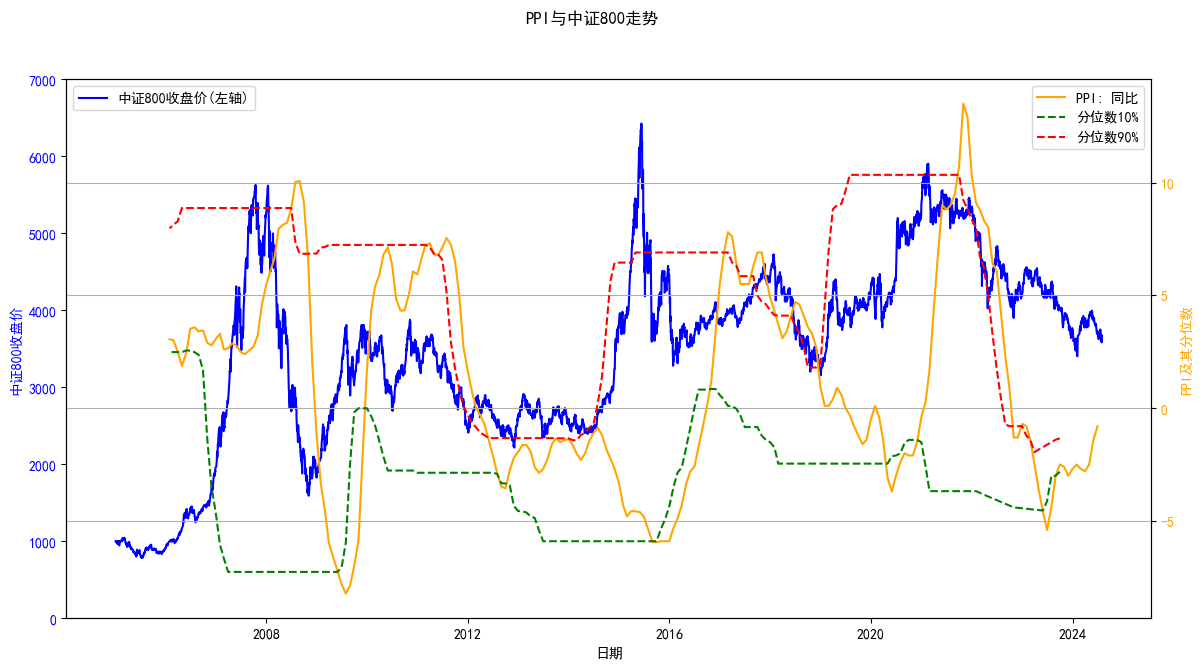

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 加载Excel文件
file_path = 'C:/Users/hp/Desktop/FOF/复现.xlsx'  # 替换为实际文件路径
xls = pd.ExcelFile(file_path)

# 读取各个表格的数据
df_ppi = pd.read_excel(file_path, sheet_name='PPI', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_ppi.columns = ['Date', 'PPI YoY']
df_ppi['Date'] = pd.to_datetime(df_ppi['Date'], format='%Y-%m-%d', errors='coerce')
df_ppi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_ppi['PPI YoY'] = pd.to_numeric(df_ppi['PPI YoY'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算每个时间点的PPI的10%和90%分位数，使用较小的滚动窗口
window_size = 30  # 滚动窗口大小
min_periods = 10  # 最小数据点数目
df_ppi['Quantile_10'] = df_ppi['PPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.10), raw=False)
df_ppi['Quantile_90'] = df_ppi['PPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.90), raw=False)

# 绘制数据
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制中证800收盘价
ax1.plot(df_csi800['Date'], df_csi800['CSI 800 Closing Price'], label='中证800收盘价(左轴)', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证800收盘价', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 7000])

# 创建另一个y轴用于PPI及其分位数
ax2 = ax1.twinx()
ax2.plot(df_ppi['Date'], df_ppi['PPI YoY'], label='PPI: 同比', color='orange')
ax2.plot(df_ppi['Date'], df_ppi['Quantile_10'], color='green', linestyle='--', label='分位数10%')
ax2.plot(df_ppi['Date'], df_ppi['Quantile_90'], color='red', linestyle='--', label='分位数90%')
ax2.set_ylabel('PPI及其分位数', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 添加标题和图例
fig.suptitle('PPI与中证800走势')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()




年化收益率: 7.82%
最大回撤: -24.98%
胜率: 27.03%
夏普比率: 2.95
卡玛比率: 0.31


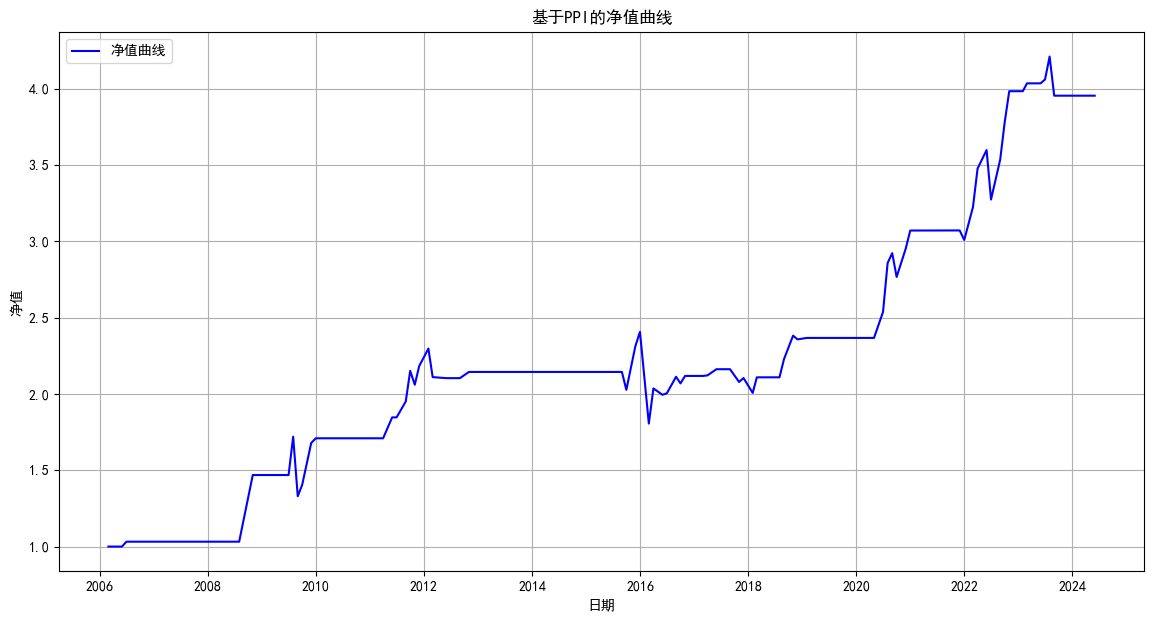

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取各个表格的数据
df_ppi = pd.read_excel(file_path, sheet_name='PPI', skiprows=4)
df_csi800 = pd.read_excel(file_path, sheet_name='中证800', skiprows=4)

# 重命名列并处理日期列
df_ppi.columns = ['Date', 'PPI YoY']
df_ppi['Date'] = pd.to_datetime(df_ppi['Date'], format='%Y-%m-%d', errors='coerce')
df_ppi.dropna(inplace=True)

df_csi800.columns = ['Date', 'CSI 800 Closing Price']
df_csi800['Date'] = pd.to_datetime(df_csi800['Date'], format='%Y-%m-%d', errors='coerce')
df_csi800.dropna(inplace=True)

# 确保所有数值列都是数值型
df_ppi['PPI YoY'] = pd.to_numeric(df_ppi['PPI YoY'], errors='coerce')
df_csi800['CSI 800 Closing Price'] = pd.to_numeric(df_csi800['CSI 800 Closing Price'], errors='coerce')

# 计算每个时间点的PPI的10%和90%分位数
window_size = 30  # 滚动窗口大小
min_periods = 10  # 最小数据点数目
df_ppi['Quantile_10'] = df_ppi['PPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.10), raw=False)
df_ppi['Quantile_90'] = df_ppi['PPI YoY'].rolling(window=window_size, min_periods=min_periods).apply(lambda x: pd.Series(x).quantile(0.90), raw=False)

# 合并中证800数据
df_merged = df_csi800.merge(df_ppi[['Date', 'PPI YoY', 'Quantile_10', 'Quantile_90']], on='Date', how='inner')

# 信号生成：PPI低于10%分位数时开多仓，高于90%分位数时空仓，否则持仓不变
df_merged['Position'] = 0
df_merged.loc[df_merged['PPI YoY'] < df_merged['Quantile_10'], 'Position'] = 1
df_merged.loc[df_merged['PPI YoY'] > df_merged['Quantile_90'], 'Position'] = -1

# 计算净值曲线
initial_value = 1  # 初始净值为1
df_merged['Return'] = df_merged['CSI 800 Closing Price'].pct_change()  # 当日的收益率
df_merged['Strategy Return'] = df_merged['Return'] * df_merged['Position'].shift(1)  # 使用前一日的仓位
df_merged['Strategy Return'].fillna(0, inplace=True)  # 将NaN值填充为0
df_merged['Net Value'] = (1 + df_merged['Strategy Return']).cumprod() * initial_value

# 计算实际交易的年份跨度
years = (df_merged['Date'].iloc[-1] - df_merged['Date'].iloc[0]).days / 365.25

# 重新计算年化收益率
if df_merged['Net Value'].iloc[-1] > 0:
    annual_return = (df_merged['Net Value'].iloc[-1] / df_merged['Net Value'].iloc[0]) ** (1 / years) - 1
else:
    annual_return = np.nan

# 计算最大回撤
cumulative_max = df_merged['Net Value'].cummax()
drawdown = (df_merged['Net Value'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 计算胜率
df_merged['Win'] = df_merged['Strategy Return'] > 0
win_rate = df_merged['Win'].mean()

# 计算夏普比率（假设无风险利率为0）
sharpe_ratio = df_merged['Strategy Return'].mean() / df_merged['Strategy Return'].std() * np.sqrt(252)

# 计算卡玛比率，如果最大回撤为零，则结果为nan
if max_drawdown < 0:
    calmar_ratio = annual_return / -max_drawdown
else:
    calmar_ratio = np.nan

# 输出指标
print(f"年化收益率: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"卡玛比率: {calmar_ratio:.2f}")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['Net Value'], label='净值曲线', color='blue')
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('基于PPI的净值曲线')
plt.legend()
plt.grid(True)
plt.show()

